In [37]:
!pip install deepxde

In [38]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

# Constantes e Parâmetros da Rede

In [39]:
SAMPLE_POINTS = 2000
T_START = 0
T_END = WIDTH = LENGTH = 1.0
ALPHA = 0.01
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
LOSS_WEIGHTS = [
    10,
    1,
    1,
    1,
    1,
    10,
]  # Pesos dos componentes da função de perda
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Equação Diferencial

In [40]:
def pde(X, T):
    # Calculate second derivatives (Hessians) of T with respect to X in both dimensions
    dT_xx = dde.grad.hessian(T, X, i=0, j=0)
    dT_yy = dde.grad.hessian(T, X, i=1, j=1)

    # Calculate first derivative (Jacobian) of T with respect to X in time dimension
    dT_t = dde.grad.jacobian(T, X, j=2)

    # Return the defined PDE
    return dT_t - ALPHA * (dT_xx + dT_yy)

# Condições de Contorno

In [41]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

# Condição inicial

In [42]:
# Define initial condition
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

# Inicializa com o campo de temperaturas sendo zero
def init_func(X):
    t = np.zeros((len(X), 1))
    return t

In [43]:
def constraint_top(X):
    return np.ones((len(X), 1)) # No contorno do topo temperatura é sempre 100 K (normalizado)

def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

# Definindo geometrias

In [44]:
# Define geometry and time domains
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])  # Geometria
timedomain = dde.geometry.TimeDomain(0, T_END)  # Tempo
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [45]:
# Condição de contorno e condição inicial
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, constraint_top, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)
ic = dde.IC(geomtime, init_func, boundary_initial)

In [46]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_up, bc_low, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

# Rede e treinamento

In [47]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)
net.apply_output_transform(lambda _, y: abs(y))
model = dde.Model(data, net)

In [48]:
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
# Train the model
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Compiling model...
Building feed-forward neural network...
'build' took 0.077967 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.046836 s

Training model...

0         [7.06e-01, 1.99e-02, 1.49e-01, 6.69e-01, 1.03e-01, 2.23e-01]    [7.06e-01, 1.99e-02, 1.49e-01, 6.69e-01, 1.03e-01, 2.23e-01]    []  
1000      [5.88e-03, 1.92e-02, 2.08e-02, 7.08e-02, 2.36e-04, 4.46e-02]    [5.88e-03, 1.92e-02, 2.08e-02, 7.08e-02, 2.36e-04, 4.46e-02]    []  
2000      [4.98e-03, 1.75e-02, 2.20e-02, 3.56e-02, 3.74e-05, 1.79e-02]    [4.98e-03, 1.75e-02, 2.20e-02, 3.56e-02, 3.74e-05, 1.79e-02]    []  
3000      [3.99e-03, 9.84e-03, 2.12e-02, 3.07e-02, 5.73e-05, 8.86e-03]    [3.99e-03, 9.84e-03, 2.12e-02, 3.07e-02, 5.73e-05, 8.86e-03]    []  
4000      [3.73e-03, 4.03e-03, 1.95e-02, 2.27e-02, 2.62e-05, 6.60e-03]    [3.73e-03, 4.03e-03, 1.95e-02, 2.27e-02, 2.62e-05, 6.60e-03]    []  
5000      [2.77e-03, 2.85e-03, 1.90e-02, 2.08e-02, 1.81e-05, 4.87e-03]    [2.77e-03, 2.85e-03, 1.90e-02, 2.08e-02, 1.81e-05, 4.87e-03]    []  
6000      [3.06e-03, 1.99e-03, 1.63e-02, 2.05e-02, 7.07e-06, 3.70e-03]    [3.06e-03, 1.99e-03, 1

In [49]:
X = geomtime.random_points(1000)
err = 1
while err > 0.01:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    # Stop training if the model isn't learning anymore
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
    model.train(
        iterations=100, disregard_previous_best=True, batch_size=BATCH_SIZE, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    dde.optimizers.set_LBFGS_options(
        maxcor=100,
    )
    losshistory, train_state = model.train(batch_size=BATCH_SIZE,)

Mean residual: 1.138e-02
Adding new point: [0.16235906 0.99631584 0.01477966] 

Compiling model...
'compile' took 0.691267 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [1.03e-02, 1.13e-03, 6.10e-03, 1.04e-02, 6.71e-06, 2.61e-03]    [5.95e-03, 1.13e-03, 6.10e-03, 1.04e-02, 6.71e-06, 2.61e-03]    []  
10100     [5.56e-03, 1.54e-03, 6.28e-03, 2.40e-02, 2.49e-05, 1.17e-02]    [5.50e-03, 1.54e-03, 6.28e-03, 2.40e-02, 2.49e-05, 1.17e-02]    []  

Best model at step 10000:
  train loss: 3.06e-02
  test loss: 2.62e-02
  test metric: []

'train' took 3.600252 s

Compiling model...
'compile' took 0.733769 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10100     [5.56e-04, 1.54e-03, 6.28e-03, 2.40e-02, 2.49e-05, 1.17e-03]    [5.50e-04, 1.5

KeyboardInterrupt: 

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


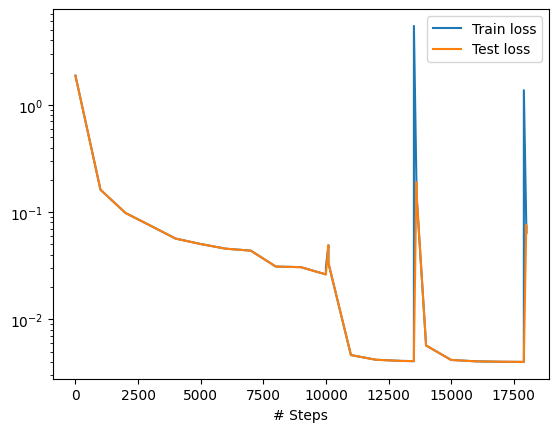

In [50]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

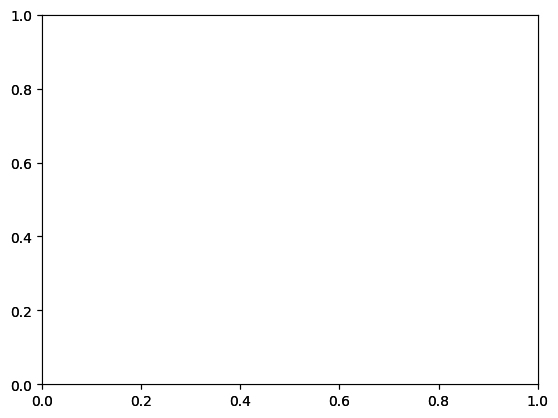

In [51]:
# Predict the solution at different time points and create an animation
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

# Set up the grid
nelx = 100  # Number of elements in x direction
nely = 100  # Number of elements in y direction
timesteps = 101  # Number of time steps
x = np.linspace(0, 1, nelx + 1)  # x coordinates
y = np.linspace(0, 1, nely + 1)  # y coordinates
t = np.linspace(0, 1, timesteps)  # Time points

# Prepare the data for the prediction
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [52]:
# Predict Solution and Residual
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  # Scale and reshape solution
residual = model.predict(test_domain, operator=pde)
residual = residual.reshape(test_x.shape)  # Reshape residuals

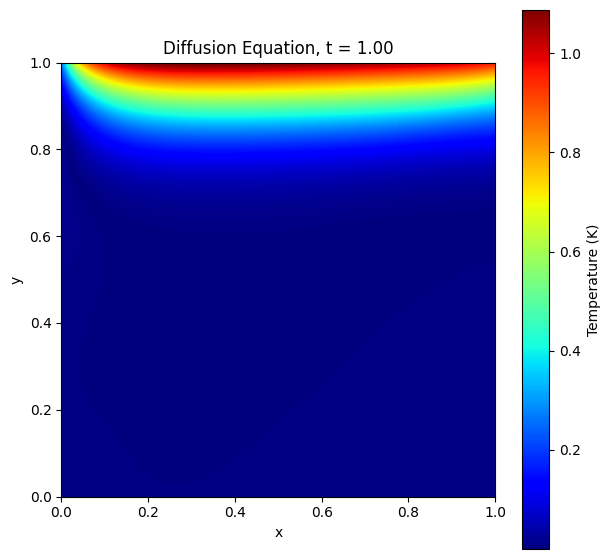

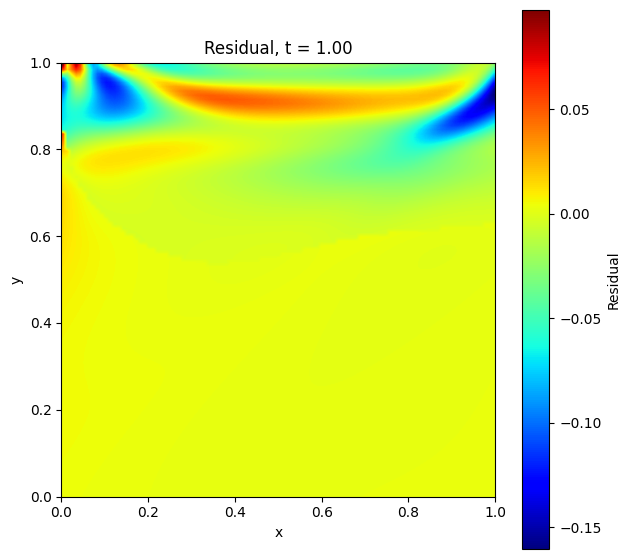

In [53]:
# Animation function
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Create initial image and colorbar
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Update function for the frames
    def updatefig(k):
        # Update image data
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Update the color limits

        # Update colorbar
        cb.update_normal(im)

        # Update title
        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


# Create and save the solution animation
animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)

# Create and save the residuals animation
animate_solution(
    residual,
    f"pinn_heat2d_residual_{str(ALPHA)}.mp4",
    "Residual",
    "Residual",
    t,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Domain parameters
W = 1
H = 1
Nx = 101
Ny = 101
ALPHA = 0.01

# Discretization
dx = W / (Nx - 1)
dy = H / (Ny - 1)
dt = min(dx**2, dy**2) / (4 * ALPHA)
total_time = 1

# Mesh grid
x = np.linspace(0, W, Nx)
y = np.linspace(0, H, Ny)
X, Y = np.meshgrid(x, y)

# Initial condition
T = np.zeros((Nx, Ny))

# Time-stepping loop for animation
time = 0
frames = []
fig, ax = plt.subplots()

def update(T):
    T_new = T.copy()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = T[i, j] + ALPHA * dt * (
                (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dx**2
                + (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dy**2
            )
    # Neumann boundary conditions
    T_new[0, :] = 0#T_new[1, :]
    T_new[:, 0] = 0#T_new[:, 1]
    T_new[:, -1] = 1#T_new[:, -2]
    # Dirichlet boundary condition
    T_new[-1, :] = 0  # Using -1 to refer to the last row

    return T_new

while time < total_time:
    T = update(T)
    time += dt
    frames.append(T.copy())

def animate(i):
    ax.clear()
    contour = ax.contourf(X, Y, frames[i].T, cmap="jet", levels=100, vmin=0, vmax=1)
    return contour

ani = animation.FuncAnimation(fig, animate, frames=len(frames), repeat=False)
ani.save("heat_distribution_animation.mp4", writer='ffmpeg', fps=30)

plt.show()
